In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import *
from pandas import DataFrame, Series

plt.style.use('seaborn')
sns.set(font_scale=2.5) 
df_train = pd.read_csv('./data/titanic_train.csv')
df_test = pd.read_csv('./data/titanic_test.csv')
train = df_train.drop(['Cabin', 'Embarked', 'Name', 'Ticket', 'PassengerId'],axis=1)
test = df_test.drop(['Cabin', 'Embarked', 'Name', 'Ticket'],axis=1)
train["Age"].fillna(train.groupby("Sex")["Age"].transform("mean"), inplace=True)
test["Age"].fillna(test.groupby("Sex")["Age"].transform("mean"), inplace=True)
test["Fare"].fillna(test.groupby("Sex")["Fare"].transform("median"), inplace=True)
sex_mapping = {"male": 0, "female": 1}
train['Sex'] = train['Sex'].map(sex_mapping)
test['Sex'] = test['Sex'].map(sex_mapping)
age_mean = train['Age'].mean()
age_std = train['Age'].std()
indexNames = train[train['Age'] < age_mean - 3*age_std].index
train.drop(indexNames , inplace=True)
indexNames = train[train['Age'] > age_mean + 3*age_std].index
train.drop(indexNames , inplace=True)
fare_mean = train['Fare'].mean()
fare_std = train['Fare'].std()
indexNames = train[train['Fare'] < fare_mean - 3*fare_std].index
train.drop(indexNames , inplace=True)
indexNames = train[train['Fare'] > fare_mean + 3*fare_std].index
train.drop(indexNames , inplace=True)

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

X_train = train.drop('Survived', axis=1).values
target_label = train['Survived'].values
X_test = test.values

In [4]:
X_train.shape, X_test.shape

((864, 6), (418, 7))

In [5]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.2, random_state=2020)
y_tr.shape, y_vld.shape

((691,), (173,))

In [6]:
model = LogisticRegression()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [7]:
print('Number of people: {} \naccuracy: {:.2f}% '.format(y_vld.shape[0], 100 * accuracy_score(y_vld,prediction)))

Number of people: 173 
accuracy: 78.03% 


In [8]:
confusion_matrix(y_vld,prediction)

array([[94, 24],
       [14, 41]])

In [9]:
print('Precision: {:.2f}% \nRecall: {:.2f}% \nF1-score: {:.2f}% '.format(100*precision_score(y_vld,prediction),
                                                                         100*recall_score(y_vld,prediction),100*f1_score(y_vld,prediction)))

Precision: 63.08% 
Recall: 74.55% 
F1-score: 68.33% 


In [10]:
list = []
for i in np.linspace(0,1,100):
    pred = model.predict_proba(X_vld)[:,1] > i
    cf_mtx = confusion_matrix(y_vld, pred)
    acc = accuracy_score(y_vld, pred)
    tpr = cf_mtx[0,0] / cf_mtx[0].sum()
    fpr = cf_mtx[1,0] / cf_mtx[1].sum()
    f1 = f1_score(y_vld, pred)
    list.append([i, acc, f1, tpr, fpr])

cut_off = DataFrame(list)
cut_off.columns = ["CUTOFF", "ACC", "F1", "TPR", "FPR"]
cut_off

,CUTOFF,ACC,F1,TPR,FPR
0,0.000000,0.317919,0.482456,0.000000,0.000000
1,0.010101,0.323699,0.484581,0.008475,0.000000
2,0.020202,0.323699,0.484581,0.008475,0.000000
3,0.030303,0.329480,0.486726,0.016949,0.000000
4,0.040404,0.329480,0.486726,0.016949,0.000000
...,...,...,...,...,...
95,0.959596,0.687861,0.100000,0.983051,0.945455
96,0.969697,0.687861,0.100000,0.983051,0.945455
97,0.979798,0.676301,0.034483,0.983051,0.981818
98,0.989899,0.676301,0.000000,0.991525,1.000000


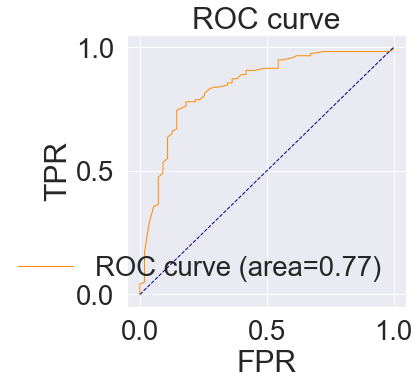

In [11]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_vld, prediction)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(cut_off["FPR"],cut_off["TPR"], color="darkorange", lw=1, label="ROC curve (area=%.2f)" %roc_auc)
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--')
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc="lower right")

In [12]:
cut_off[cut_off["ACC"] == cut_off["ACC"].max()]

,CUTOFF,ACC,F1,TPR,FPR
70,0.707071,0.803468,0.653061,0.90678,0.418182


In [13]:
cut_off_ACC_MAX = cut_off[cut_off["ACC"] == cut_off["ACC"].max()]["CUTOFF"][70]
cut_off_ACC_MAX

0.7070707070707072